1:03:40

# <b>PA005: High Value Customer Identification (Insiders)</b>

### 0.0 Imports

In [1]:
import re
import numpy   as np
import pandas  as pd
import seaborn as sns

import plotly.express    as px
import matplotlib.pyplot as plt

from matplotlib import colormaps

from sklearn.cluster       import KMeans, DBSCAN
from sklearn.metrics       import silhouette_score, silhouette_samples
from sklearn.manifold      import TSNE
from sklearn.ensemble      import RandomForestRegressor
from sklearn.mixture       import GaussianMixture
from sklearn.neighbors     import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import sklearn.preprocessing as pp

import umap.umap_ as umap

### 0.2 Load dataset

In [2]:
# load data
df_raw = pd.read_csv('data/raw/Ecommerce.csv', encoding='latin')

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )


df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## <font color="blue">1.0 Descrição dos dados </font>

In [3]:
df1 = df_raw.copy()

### 1.1 Rename columns

In [4]:
cols_name = df1.columns

df1.columns = map( lambda col: re.sub(r'([a-z])([A-Z])', r'\1_\2', col).lower(), cols_name )

df1.columns


Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.2 Data dimensions

In [5]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

### 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### 1.5 Replace NA

In [8]:
df_missing     = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

df_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom


In [9]:
# dataframe com os códigos de transação de compras sem identificação do cliente
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange( 19000, 19000 + df_backup.shape[0], 1 )

# merge with original
df1 = pd.merge( df1, df_backup, how='left', on='invoice_no')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

### 1.6 Change dtypes

In [10]:
# converte para o tipo 'datetime64[ns]'
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# converte para o tipo inteiro
df1['customer_id'] = df1['customer_id'].astype( int )

In [11]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

### 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

#### 1.7.1 Numerical Attributes

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply(np.median) ).T

# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
desc_stats = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
desc_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurt']

desc_stats

,attributes,min,max,range,mean,median,std,skew,kurt
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1 Categorical Attributes

## <font color="blue">2.0 Filtragem de Variáveis </font>

In [14]:
df2 = df1.copy()

In [15]:
# ==== Numerical Attributes =========
# unit price > 0.04 - elimina possíveis brindes
df2 = df2.query('unit_price > 0.04')

# ==== Categorical attributes =======
# stock code != ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']
df2 = df2.query("stock_code not in ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']")

# description
df2 = df2.drop(columns=['description'], axis=1)

# country - elimina falsos paises
df2 = df2.query("country not in ['Unspecified', 'European Community']")

# bad users
df2 = df2.query('customer_id not in [16446]')

# dividindo o dataset entre compras e devoluções
df2_returns  = df2.query('quantity < 0')
df2_purchases = df2.query('quantity > 0')

## <font color="blue">3.0 Feature Engineering </font>

In [16]:
df3 = df2.copy()

### 3.1 Feature Creation

In [17]:
# data reference
df_ref = df3[['customer_id']].drop_duplicates(ignore_index=True)

df_ref.shape

(5786, 1)

#### 3.1.1 Gross Revenue

In [18]:
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

df_monetary = ( df2_purchases[['customer_id', 'gross_revenue']]
                    .groupby('customer_id')
                    .sum()
                    .reset_index()
            )

df_ref = pd.merge(left=df_ref, right=df_monetary, how='left', on='customer_id')

df_ref.isna().sum()


/tmp/ipykernel_29046/599400605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


customer_id       0
gross_revenue    91
dtype: int64

#### 3.1.2 Recency - Days from lastest purchase on the dataset

In [19]:
df_recency = ( df2_purchases[['customer_id', 'invoice_date']]
                    .groupby('customer_id')
                    .max()
                    .reset_index()
            )

df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

df_ref = pd.merge(left=df_ref, right=df_recency, how='left', on='customer_id')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

#### 3.1.5 Amount of products bought

In [20]:
df_products = ( df2_purchases[['customer_id', 'stock_code']]
                    .groupby('customer_id')
                    .count()
                    .reset_index()
        ).rename(columns={'stock_code': 'total_products'})


df_ref = pd.merge(left=df_ref, right=df_products, how='left', on='customer_id')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
dtype: int64

#### 3.1.8 Frequency Purchase

In [21]:
df_aux =  ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']]
              .drop_duplicates()
              .groupby('customer_id')
              .agg(
                    max_date=('invoice_date', 'max'),
                    min_date=('invoice_date', 'min'),
                    orders=('invoice_date', 'count'),
                  )
              .reset_index()
        )

df_aux['days'] = ( df_aux['max_date'] - df_aux['min_date'] ).dt.days

df_aux['frequency'] = df_aux[['orders', 'days']].apply( lambda x: x['orders'] / x['days'] if x['days'] != 0 else 0, axis=1)

df_aux.head()

,customer_id,max_date,min_date,orders,days,frequency
0,12346,2017-01-16,2017-01-16,1,0,0.000000
1,12347,2017-12-05,2016-12-05,7,365,0.019178
2,12348,2017-09-23,2016-12-14,4,283,0.014134
3,12349,2017-11-19,2017-11-19,1,0,0.000000
4,12350,2017-01-31,2017-01-31,1,0,0.000000


In [22]:
df_aux.sort_values('frequency', ascending=False)

,customer_id,max_date,min_date,orders,days,frequency
4007,17850,2016-11-30,2016-11-29,34,1,34.0
4219,18139,2017-11-20,2017-11-19,6,1,6.0
1979,15060,2017-11-29,2017-11-28,4,1,4.0
2461,15700,2017-06-18,2017-06-17,2,1,2.0
3395,16986,2017-11-08,2017-11-07,2,1,2.0
...,...,...,...,...,...,...
788,13398,2017-05-29,2017-05-29,1,0,0.0
790,13403,2017-11-20,2017-11-20,1,0,0.0
777,13382,2017-03-02,2017-03-02,1,0,0.0
779,13385,2017-01-12,2017-01-12,1,0,0.0


In [23]:
df_aux = df_aux[['customer_id', 'frequency']]

df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
frequency         91
dtype: int64

#### 3.1.9 Number of returns

In [24]:
df_aux = ( df2_returns[['customer_id', 'quantity']]
            .groupby('customer_id')
            .sum()
            .reset_index()
            .rename(columns={'quantity': 'items_returned'})
    )

df_aux['items_returned'] = -1 * df_aux['items_returned']

df_ref = pd.merge(left=df_ref, right=df_aux, on='customer_id', how='left')

df_ref.isna().sum()

customer_id          0
gross_revenue       91
recency_days        91
total_products      91
frequency           91
items_returned    4191
dtype: int64

In [25]:
df_ref.loc[ df_ref['items_returned'].isna(), 'items_returned' ] = 0

df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
frequency         91
items_returned     0
dtype: int64

### 3.2 Final Result

In [26]:
df_ref.isna().sum()

customer_id        0
gross_revenue     91
recency_days      91
total_products    91
frequency         91
items_returned     0
dtype: int64

## <font color="blue">4.0 Exploratory Data Analysis </font>

In [27]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id       0
gross_revenue     0
recency_days      0
total_products    0
frequency         0
items_returned    0
dtype: int64

### 4.3 Estudo do Espaço

In [28]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

df43.head()

,gross_revenue,recency_days,total_products,frequency,items_returned
0,5391.21,372.0,297.0,34.000000,40.0
1,3232.59,56.0,171.0,0.028391,35.0
2,6705.38,2.0,232.0,0.040431,50.0
3,948.25,95.0,28.0,0.017986,0.0
4,876.00,333.0,3.0,0.075000,22.0


In [29]:
mms = pp.MinMaxScaler()

scaled_features = mms.fit_transform(df43)

df43 = pd.DataFrame(data=scaled_features, columns=df43.columns)

cols_selected = ['gross_revenue', 'recency_days', 'total_products', 'frequency', 'items_returned']

df43 = df43[cols_selected]
df43.head()

,gross_revenue,recency_days,total_products,frequency,items_returned
0,0.019312,0.997319,0.037774,1.000000,0.000539
1,0.011579,0.150134,0.021695,0.000835,0.000472
2,0.024020,0.005362,0.029479,0.001189,0.000674
3,0.003396,0.254692,0.003446,0.000529,0.000000
4,0.003137,0.892761,0.000255,0.002206,0.000296


In [30]:
X = df43.values

#### 4.3.2 UMAP

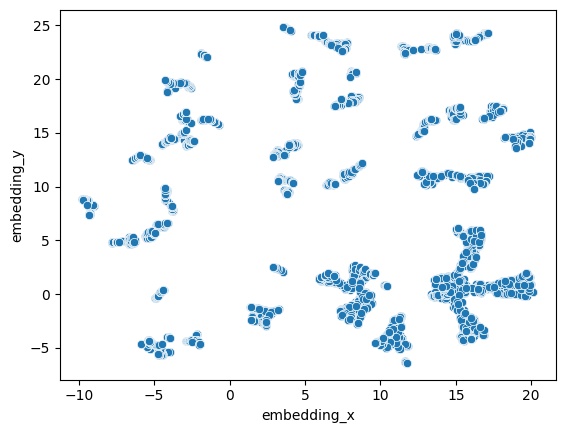

In [31]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X)

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

#### 4.3.3 T-SNE

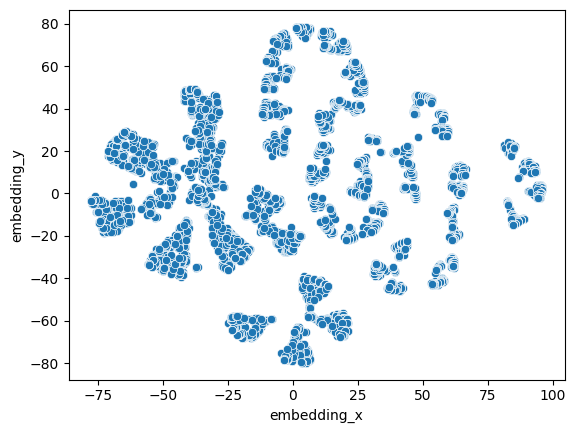

In [32]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

#### 4.3.4 Tree-Based Embedding

In [33]:
df43 = df4.drop(columns=['customer_id'], axis=1)

In [34]:
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# leaf
df_leaf = pd.DataFrame( rf_model.apply(X) )

# dataframe leaf
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6430,7005,6932,6399,6581,6822,6873,6925,6956,6504,...,6963,6520,7007,6694,6700,6646,6506,6543,6571,6831
1,6401,6285,5951,6284,6367,6551,6333,6012,6840,6321,...,6356,6064,6865,6332,6199,6311,6472,6405,6404,5874
2,5550,6456,6861,6352,6526,6780,6306,6842,6819,6919,...,6446,6439,6908,6330,6296,6583,6456,6380,6540,6770
3,3384,3413,3305,2947,2434,4314,3986,3422,3588,3155,...,4099,3083,3254,3765,3060,3242,3388,3658,3378,3580
4,2462,3176,2965,3321,2619,4580,3375,3870,3208,2734,...,3364,3348,2936,2657,2956,2417,3658,3025,3573,3420


/home/gustavo/.pyenv/versions/3.11.4/envs/ds-clusterizacao/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:301: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


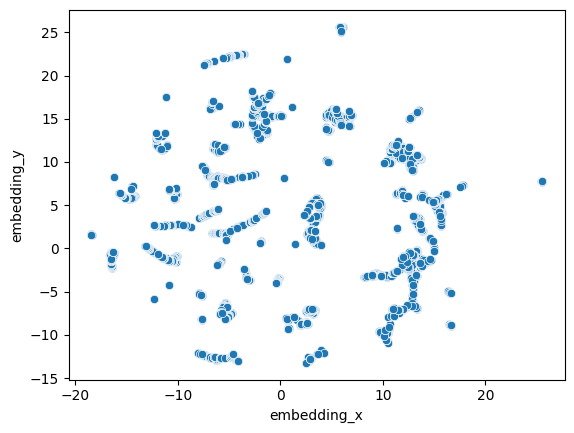

In [35]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

## <font color="blue">5.0 Data Preparation </font>

In [36]:
# Tree-Based Embedding
df5 = df_tree.copy()
df5.to_csv('src/data/tree-based-embedding.csv', index=False)

# # UMAP Embedding
# df5 = df_umap.copy()
# df5.to_csv('src/data/umap-embedding.csv', index=False)

# # T-SNE Embedding
# df5 = df_tsne.copy()
# df5.to_csv('src/data/tsne-embedding.csv', index=False)

## <font color="blue">7.0 Hyperparameter Fine-Tuning </font>

In [37]:
# X = df6.drop(columns=['customer_id'])
X = df5.copy()

In [38]:
X.head()

,embedding_x,embedding_y
0,12.923491,-4.681292
1,14.048775,-1.449850
2,12.954247,-4.029550
3,2.662126,1.539440
4,3.632200,-12.212267


In [39]:
clusters = np.arange(2, 25)

### 7.1 K-Means

In [40]:
kmeans_list = []

for k in clusters:
    
    # model definition
    kmeans_model = KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    ss_score = silhouette_score(X, labels, metric='euclidean')

    kmeans_list.append(ss_score)

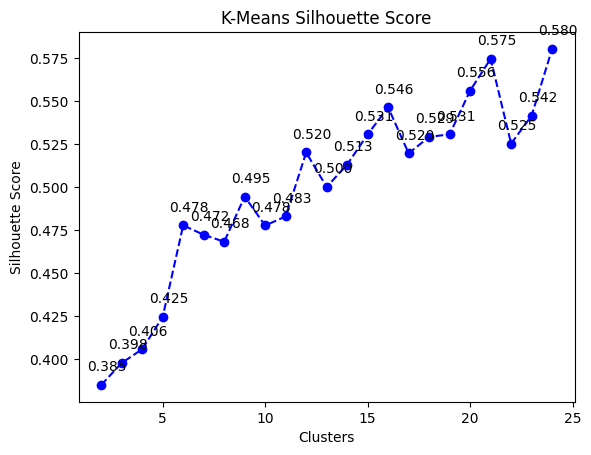

In [41]:
fig, ax = plt.subplots()

ax.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')

for x, y in zip(clusters, kmeans_list):
    point_label = '{:.3f}'.format(y)
    ax.annotate(point_label, (x,y), textcoords='offset points', xytext=(-10,10))

ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('K-Means Silhouette Score');

### 7.2 Gaussian Mixture Model

In [42]:
gmm_list = []

for k in clusters:

    # model definition
    gmm_model = GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    ss_score = silhouette_score(X, labels, metric='euclidean')
    
    gmm_list.append(ss_score)

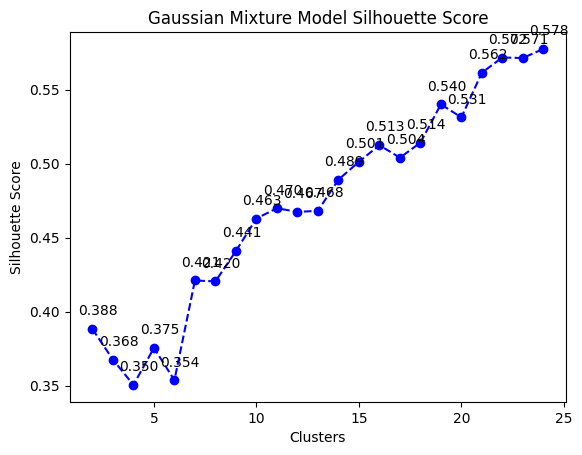

In [43]:
fig, ax = plt.subplots()

ax.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')

for x, y in zip(clusters, gmm_list):
    point_label = '{:.3f}'.format(y)
    ax.annotate(point_label, (x,y), textcoords='offset points', xytext=(-10,10))

ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Gaussian Mixture Model Silhouette Score');

### 7.3 Hierarquical Clustering

https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.cluster.hierarchy.linkage.html

In [44]:
hc_list = []

for k in clusters:

    # model definition and training
    linkage_matrix = linkage(X, method='ward')

    # model predict
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')

    # metrics
    ss_score = silhouette_score(X, labels, metric='euclidean')

    hc_list.append(ss_score)

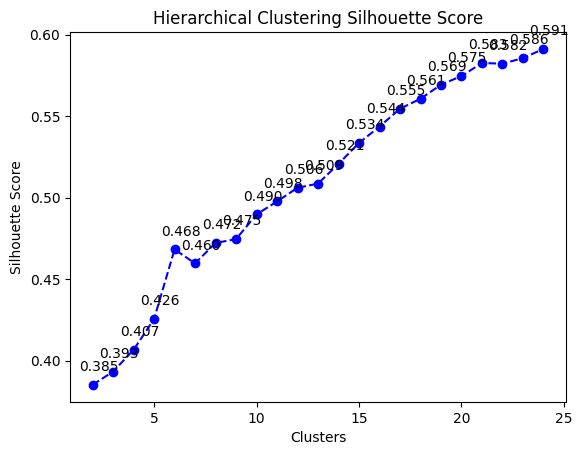

In [45]:
fig, ax = plt.subplots()

ax.plot( clusters, hc_list, linestyle='--', marker='o', color='b')

for x, y in zip(clusters, hc_list):
    point_label = '{:.3f}'.format(y)
    ax.annotate(point_label, (x,y), textcoords='offset points', xytext=(-10,10))

ax.set_xlabel('Clusters')
ax.set_ylabel('Silhouette Score')
ax.set_title('Hierarchical Clustering Silhouette Score');

### 7.5 Results

In [46]:
# Tree-Based Embedding
df_results = pd.DataFrame(
    data={
        'KMeans': kmeans_list,
        'GMM': gmm_list,
        'HC': hc_list,
        #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.385174,0.397913,0.405942,0.424662,0.477895,0.472434,0.468393,0.494593,0.477817,0.483089,0.520243,0.500206,0.513213,0.530755,0.546435,0.519773,0.529297,0.530804,0.556188,0.574701,0.525388,0.541606,0.580428
GMM,0.388235,0.367556,0.350489,0.375489,0.353662,0.421074,0.420466,0.441021,0.462965,0.469949,0.467435,0.468162,0.489217,0.501310,0.512546,0.504088,0.514207,0.540162,0.531322,0.561584,0.571802,0.571464,0.577605
HC,0.385168,0.393335,0.406672,0.425601,0.468250,0.459741,0.472234,0.474592,0.489730,0.497687,0.506095,0.508620,0.520751,0.533557,0.543641,0.554540,0.560679,0.569300,0.574598,0.582635,0.582183,0.585619,0.591245


In [47]:
# UMAP Embedding
df_results = pd.DataFrame(
    data={
        'KMeans': kmeans_list,
        'GMM': gmm_list,
        'HC': hc_list,
        #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.385174,0.397913,0.405942,0.424662,0.477895,0.472434,0.468393,0.494593,0.477817,0.483089,0.520243,0.500206,0.513213,0.530755,0.546435,0.519773,0.529297,0.530804,0.556188,0.574701,0.525388,0.541606,0.580428
GMM,0.388235,0.367556,0.350489,0.375489,0.353662,0.421074,0.420466,0.441021,0.462965,0.469949,0.467435,0.468162,0.489217,0.501310,0.512546,0.504088,0.514207,0.540162,0.531322,0.561584,0.571802,0.571464,0.577605
HC,0.385168,0.393335,0.406672,0.425601,0.468250,0.459741,0.472234,0.474592,0.489730,0.497687,0.506095,0.508620,0.520751,0.533557,0.543641,0.554540,0.560679,0.569300,0.574598,0.582635,0.582183,0.585619,0.591245


In [48]:
# T-SNE Embedding
df_results = pd.DataFrame(
    data={
        'KMeans': kmeans_list,
        'GMM': gmm_list,
        'HC': hc_list,
        #'DBSCAN': dbscan_list
    }
).T

df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.385174,0.397913,0.405942,0.424662,0.477895,0.472434,0.468393,0.494593,0.477817,0.483089,0.520243,0.500206,0.513213,0.530755,0.546435,0.519773,0.529297,0.530804,0.556188,0.574701,0.525388,0.541606,0.580428
GMM,0.388235,0.367556,0.350489,0.375489,0.353662,0.421074,0.420466,0.441021,0.462965,0.469949,0.467435,0.468162,0.489217,0.501310,0.512546,0.504088,0.514207,0.540162,0.531322,0.561584,0.571802,0.571464,0.577605
HC,0.385168,0.393335,0.406672,0.425601,0.468250,0.459741,0.472234,0.474592,0.489730,0.497687,0.506095,0.508620,0.520751,0.533557,0.543641,0.554540,0.560679,0.569300,0.574598,0.582635,0.582183,0.585619,0.591245


## <font color="blue">8.0 Model Training </font>

### 8.1 K-Means

In [49]:
# model definition
k_best = 8
kmeans = KMeans(init='random', n_clusters=k_best, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X.values)

# clustering
labels = kmeans.labels_

In [50]:
# WCSS (Within-Cluster Sum of Square)
print('WCSS value\t: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
ss_value = silhouette_score(X, labels, metric='euclidean')
print('SS value\t: {}'.format(ss_value))

WCSS value	: 97783.921875


SS value	: 0.4633704125881195


## <font color="blue">9.0 Cluster Analysis </font>

In [51]:
df9 = X.copy()

df9['cluster'] = labels
df9.head()

,embedding_x,embedding_y,cluster
0,12.923491,-4.681292,6
1,14.048775,-1.449850,6
2,12.954247,-4.029550,6
3,2.662126,1.539440,7
4,3.632200,-12.212267,5


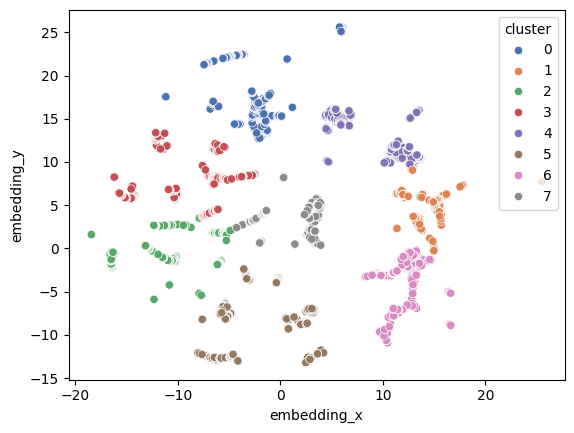

In [52]:
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

### 9.4 Cluster Profile

In [53]:
df9 = df4.copy()
df9['cluster'] = labels

In [54]:
# Number of customers
df_cluster = ( df9[['customer_id', 'cluster']]
                .groupby('cluster')
                .count()
                .reset_index()

        ).rename(columns={'customer_id': 'customers'})

df_cluster['perc_customer'] = 100 * df_cluster['customers'] / df_cluster['customers'].sum()

# Avg gross revenue
df_gross_revenue = ( df9[['gross_revenue', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_gross_revenue, how='left', on='cluster')


# Avg recency days
df_recency = ( df9[['recency_days', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_recency, how='left', on='cluster')


# Avg frequency
df_frequency = ( df9[['frequency', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_frequency, how='left', on='cluster')


df_total_products = ( df9[['total_products', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_total_products, how='left', on='cluster')


df_items_returned = ( df9[['items_returned', 'cluster']]
                        .groupby('cluster')
                        .mean()
                        .reset_index()
            )

df_cluster = pd.merge(left=df_cluster, right=df_items_returned, how='left', on='cluster')


df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,total_products,items_returned
0,0,673,11.817384,283.717756,183.478455,0.000071,16.735513,0.786033
1,1,613,10.763828,2032.089299,105.265905,0.016739,135.004894,6.755302
2,2,478,8.393327,191.410481,194.382845,0.000111,10.435146,0.466527
3,3,701,12.309043,307.079586,150.261056,0.000509,20.246790,0.623395
4,4,897,15.750658,1413.757157,74.494983,0.027210,68.149387,11.982163
5,5,809,14.205443,523.286588,136.881335,0.042372,23.250927,1.577256
6,6,983,17.260755,6303.541292,57.601221,0.085486,325.632757,155.528993
7,7,541,9.499561,874.462939,84.044362,0.033328,26.073937,14.480591


In [55]:
most_valuable_cluster = df_cluster.sort_values('gross_revenue', ascending=False)['cluster'].values
new_cluster_labels = np.arange(k_best)
dict_cluster = dict(zip(most_valuable_cluster, new_cluster_labels))

df_cluster['cluster'] = df_cluster['cluster'].map(dict_cluster)

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)
df_cluster

,cluster,customers,perc_customer,gross_revenue,recency_days,frequency,total_products,items_returned
6,0,983,17.260755,6303.541292,57.601221,0.085486,325.632757,155.528993
1,1,613,10.763828,2032.089299,105.265905,0.016739,135.004894,6.755302
4,2,897,15.750658,1413.757157,74.494983,0.027210,68.149387,11.982163
7,3,541,9.499561,874.462939,84.044362,0.033328,26.073937,14.480591
5,4,809,14.205443,523.286588,136.881335,0.042372,23.250927,1.577256
3,5,701,12.309043,307.079586,150.261056,0.000509,20.246790,0.623395
0,6,673,11.817384,283.717756,183.478455,0.000071,16.735513,0.786033
2,7,478,8.393327,191.410481,194.382845,0.000111,10.435146,0.466527


In [56]:
most_valuable_cluster_index = np.argsort(most_valuable_cluster)

labels = most_valuable_cluster_index[labels]
labels

array([0, 0, 0, ..., 4, 0, 5])

0 - Cluster Insiders

1 - Cluster More Products (queremos que eles comprem mais produtos)

2 - Cluster Spend Money

3 - Cluster Even More Products

4 - Cluster Less Days (Baixa Recência - maior valor)

5 - Cluster Less 1k

6 - Cluster Stop Returners

7 - Cluster More Buy

## <font color="blue">10.0 Análise Explatória dos Clusters </font>

In [57]:
df10 = df9[['customer_id'] + cols_selected].copy()
df10['cluster'] = labels

In [58]:
df10.head()

,customer_id,gross_revenue,recency_days,total_products,frequency,items_returned,cluster
0,17850,5391.21,372.0,297.0,34.000000,40.0,0
1,13047,3232.59,56.0,171.0,0.028391,35.0,0
2,12583,6705.38,2.0,232.0,0.040431,50.0,0
3,13748,948.25,95.0,28.0,0.017986,0.0,3
4,15100,876.00,333.0,3.0,0.075000,22.0,4


## <font color="blue">11.0 Deploy to Production </font>

In [59]:
df10['recency_days'] = df10['recency_days'].astype(int)
df10['total_products'] = df10['total_products'].astype(int)
df10['items_returned'] = df10['items_returned'].astype(int)

In [60]:
from sqlalchemy import create_engine, text

In [61]:
# database connection
engine = create_engine('sqlite:///insiders_db.sqlite')

# # drop table
# query_drop_insiders = """
#     DROP TABLE insiders
# """

# create table
query_create_insiders = """
    CREATE TABLE insiders (
        customer_id     INTEGER,
        gross_revenue   REAL,
        recency_days    INTEGER,
        total_products  INTEGER,
        frequency       REAL,
        items_returned  INTEGER,
        cluster         INTEGER
    )
"""

conn = engine.connect()

# conn.execute(text(query_drop_insiders))
conn.execute(text(query_create_insiders))

In [62]:
# insert data into
df10.to_sql('insiders', con=engine.connect(), if_exists='append', index=False)

5695

In [63]:
# get query
query_collect = """
    SELECT * FROM insiders
"""

df = pd.read_sql_query(query_collect, conn)
df.head()

,customer_id,gross_revenue,recency_days,total_products,frequency,items_returned,cluster
0,17850,5391.21,372,297,34.000000,40,0
1,13047,3232.59,56,171,0.028391,35,0
2,12583,6705.38,2,232,0.040431,50,0
3,13748,948.25,95,28,0.017986,0,3
4,15100,876.00,333,3,0.075000,22,4
